In [1]:
import os
import sys
import ast
import cv2
import json
import shutil
import random
import pickle
import imageio
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
from pprint import pprint
import matplotlib.pyplot as plt
sys.path.append('./')
from utils import normalize_image, plot_image, plot_images

In [14]:
# root_dir = '/data/jupiter/datasets/Jupiter_train_v5_11'
# root_dir = '/data/jupiter/datasets/Jupiter_train_v5_11_20230508'
# root_dir = '/data2/jupiter/datasets/Jupiter_train_v6_1_v2'
# root_dir = '/data2/jupiter/datasets/Jupiter_train_v6_2'
root_dir = '/data2/jupiter/datasets/halo_rgb_stereo_train_v6_1'
# root_dir = '/data/jupiter/datasets/Jupiter_20230801_20231011_stop_event_labeling_candidates'
# root_dir = '/data/jupiter/datasets/Jupiter_train5_11_driveable_not_labeled_on_harvest'
# root_dir = '/data/jupiter/datasets/Jupiter_halo_labeled_data_20230427_stereo_640'
# root_dir = '/data/jupiter/datasets/Jupiter_halo_labeled_data_20230427_stereo_768'
# root_dir = '/data/jupiter/datasets/20230823_labeled_right_images_12k'
# root_dir = '/data/jupiter/li.yu/data/Jupiter_2023_04_05_loamy869_dust_collection_stereo'
# root_dir = '/data/jupiter/li.yu/data/left_and_right_labels_samples'
# root_dir = '/data/jupiter/li.yu/data/Jupiter_2022_Dust_Humans_Unfiltered_partiallabeled'
# csv = os.path.join(root_dir, '642ba9506651c8d5688518e0_master_annotations_ppcutnpastecolumns.csv')
csv = os.path.join(root_dir, 'master_annotations_dedup.csv')
# csv = os.path.join(root_dir, 'v61base_epoch0_5_30_focal05_master_annotations.csv')
converters = {"label_map": ast.literal_eval, "label_counts": ast.literal_eval}
df = pd.read_csv(csv, converters=converters)
df.shape

/home/li.yu/anaconda3/envs/pytorchlightning/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (1,2,23,81,92,93,94,95,96,98,99,101,102,103,104,105,106,107,108,109,119,152,156,157,162,173,176,179,180,186,188,198,199,201,202,203,204,224,229,230,231,234,236,238,239,250,251,253,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,274,278,279,280,283,284,285,287) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(147222, 325)

In [15]:
# load cutnpaste columns
# df2 = pd.read_parquet('/data2/jupiter/datasets/Jupiter_train_v6_2/cache/cutnpaste_961706335.parquet')
df2 = pd.read_csv('/data2/jupiter/datasets/halo_rgb_stereo_train_v6_1/cache/cutnpaste_1553242183.csv')
df2.shape

(147222, 344)

In [16]:
set(df2.columns) - set(df.columns)

{'brightness',
 'color_transfer_npz_save_path',
 'humans_max_col',
 'humans_max_row',
 'humans_min_col',
 'humans_min_row',
 'humans_pixel_count',
 'is_humans_present_in_annotations',
 'is_laying_down_human',
 'is_multi_human',
 'is_standing_human',
 'is_tractors_or_vehicles_present_in_annotations',
 'label_counts',
 'occluded_humans',
 'tractors_or_vehicles_max_col',
 'tractors_or_vehicles_max_row',
 'tractors_or_vehicles_min_col',
 'tractors_or_vehicles_min_row',
 'tractors_or_vehicles_pixel_count'}

In [4]:
df2['is_humans_present_in_annotations'] = df2['humans_pixel_count'] > 0
df2['is_tractors_or_vehicles_present_in_annotations'] = df2['tractors_or_vehicles_pixel_count'] > 0
print(df2.columns)
common_columns = ['brightness', 'label_counts', 
       'humans_pixel_count', 'humans_max_row', 'humans_min_row',
       'humans_max_col', 'humans_min_col', 'is_multi_human',
       'is_standing_human', 'is_laying_down_human', 'occluded_humans',
       'tractors_or_vehicles_pixel_count', 'tractors_or_vehicles_max_row',
       'tractors_or_vehicles_min_row', 'tractors_or_vehicles_max_col',
       'tractors_or_vehicles_min_col',
       'is_humans_present_in_annotations',
       'is_tractors_or_vehicles_present_in_annotations']
common_columns = set(common_columns).intersection(list(df.columns))
# drop columns in df
df.drop(common_columns, axis=1, inplace=True)
print(df.shape)
df1 = df.merge(df2, on='unique_id')
print(df1.shape)

Index(['brightness', 'label_counts', 'Airborne-debris', 'Driveable',
       'humans_pixel_count', 'humans_max_row', 'humans_min_row',
       'humans_max_col', 'humans_min_col', 'is_multi_human',
       'is_standing_human', 'is_laying_down_human', 'occluded_humans',
       'tractors_or_vehicles_pixel_count', 'tractors_or_vehicles_max_row',
       'tractors_or_vehicles_min_row', 'tractors_or_vehicles_max_col',
       'tractors_or_vehicles_min_col', 'unique_id',
       'is_humans_present_in_annotations',
       'is_tractors_or_vehicles_present_in_annotations'],
      dtype='object')
(318874, 416)
(318874, 436)


In [13]:
# update stereo_pipeline_npz_save_path with clean depth
df2 = pd.read_csv('/data2/jupiter/datasets/Jupiter_train_v6_2/master_annotations_20231019_clean.csv')
print(df2.shape)
df1.drop(columns=['stereo_pipeline_npz_save_path'], axis=1, inplace=True)
print(df1.shape)
df1 = df1.merge(df2[['id', 'stereo_pipeline_npz_save_path']], on='id')
print(df1.shape)
df1.to_csv('/data2/jupiter/datasets/Jupiter_train_v6_2/master_annotations_20231019_clean_fl05.csv', index=False)

/home/li.yu/anaconda3/envs/pytorchlightning/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (7,8,40,59,60,61,62,64,65,66,67,68,69,70,71,72,73,74,76,77,78,79,81,82,83,84,85,86,87,88,89,90,91,110,111,112,113,115,116,117,118,119,120,121,122,123,124,125,144,145,146,147,149,150,151,152,153,154,155,156,157,158,159,161,162,163,164,166,167,168,169,170,171,172,173,174,175,176,178,179,180,181,183,184,185,186,187,188,189,190,191,192,193,224,226,228,231,248,252,255,256,262,263,264,268,309,320,325,327,328,338,339,347,355,371,372,374,375,377,378) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(321638, 425)
(318874, 435)
(318874, 436)


In [4]:
df1 = df.copy()
# df2 = df.copy()
print(df1.shape, df2.shape)
print(set(df1.columns) - set(df2.columns))
print(set(df2.columns) - set(df1.columns))

(318874, 434) (321638, 19)
{'artifacts_content_hash', 'artifact_raw_0_data_category', 'hdr_library', 'operation_time', 'artifact_debayeredrgb_0_data_category', 'artifact_debayeredrgb_0_content_hash', 'label_map', 'annotation_pixelwise_0_vendor_metadata', 'jupiter_simpleui_hash', 'dummy_gps', 'artifact_rectified_0_image', 'mime_type', 'artifact_segconf_0_image', 'jupiter_libs_intel__jupiter_utils', 'updated_at', 'water_management', 'geohash', 'hdr_algo', 'artifact_detections_0_updated_at', 'artifact_rgb_0_id', 'annotation_pixelwise_0_aletheia_id', 'libsgm', 'annotation_pixelwise_0_id', 'annotation_pixelwise_0_label_map', 'artifact_detections_0_is_archived', 'artifact_debayeredrgb_0_s3_bucket', 'rectified_stereo_output_width', 'annotation_pixelwise_0_audit_by', 'artifact_detections_0_created_at', 'annotation_pixelwise_0_created_at', 'artifact_segmap_0_web_s3_key', 'location_human_tagged', 'plug_repurposed', 'artifact_rectified_0__id', 'image_id', 'date', 'receiving_human_tagged', 'grower

In [22]:
df1.iloc[0].stereo_pipeline_npz_save_path, df2.iloc[0].stereo_pipeline_npz_save_path

('processed_20231019_clean/images/614d0eb90f7787d7ba7d1e43/stereo_output.npz',
 'processed_20231019_clean/images/614d0eb90f7787d7ba7d1e43/stereo_output.npz')

In [15]:
# df2['stereo_pipeline_npz_save_path'] = df2['stereo_pipeline_npz_save_path'].apply(lambda p: p[43:])
# df2['rectified_label_save_path'] = df2['rectified_label_save_path'].apply(lambda p: p[43:])
# df2 = df2.drop('color_transfer_npz_save_path', axis=1)
# df2.iloc[0].stereo_pipeline_npz_save_path, df2.iloc[0].rectified_label_save_path

('processed/images/614d0eb90f7787d7ba7d1e43/stereo_output.npz',
 'processed/images/614d0eb90f7787d7ba7d1e43/rectification_output_61dd087a50a352ea47e1e4b4.npz')

### Check overlap with test sets

In [5]:
safety_csv = '/data/jupiter/datasets/humans_on_path_test_set_2023_v15_anno/master_annotations.csv'
safety_df = pd.read_csv(safety_csv)
print(safety_df.shape)
overlap_df = df[df.id.isin(safety_df.id)]
print(overlap_df.shape)

(19846, 234)
(99, 302)


/home/li.yu/anaconda3/envs/pytorchlightning/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (92,93,157,210) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Load label count file

In [26]:
# get human and vehicle counts in images
def convert_label_column(row):
    row['Humans'] = row["label_counts"].get("Humans", 0)
    row['Vehicles'] = row["label_counts"].get("Tractors or Vehicles", 0)
    return row
df = df.apply(lambda row: convert_label_column(row), axis=1)
df.shape

(321638, 426)

Human stats:
Human images 10752 out of 38952, ratio 0.276
front day 1412 ratio 0.036, night 1925 ratio 0.049, sum 3337 ratio 0.086
rear day 5057 ratio 0.130, night 2358 ratio 0.061, sum 7415 ratio 0.190
cut df to 10496 by {'Humans': 50000}


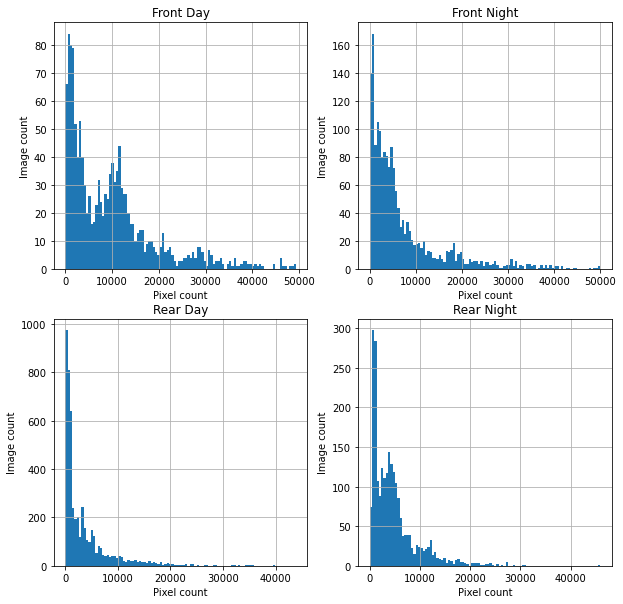

Vehicle stats:
Vehicle images 3499 out of 38952, ratio 0.090
front day 937 ratio 0.024, night 484 ratio 0.012, sum 1421 ratio 0.036
rear day 1665 ratio 0.043, night 413 ratio 0.011, sum 2078 ratio 0.053
cut df to 3411 by {'Vehicles': 80000}


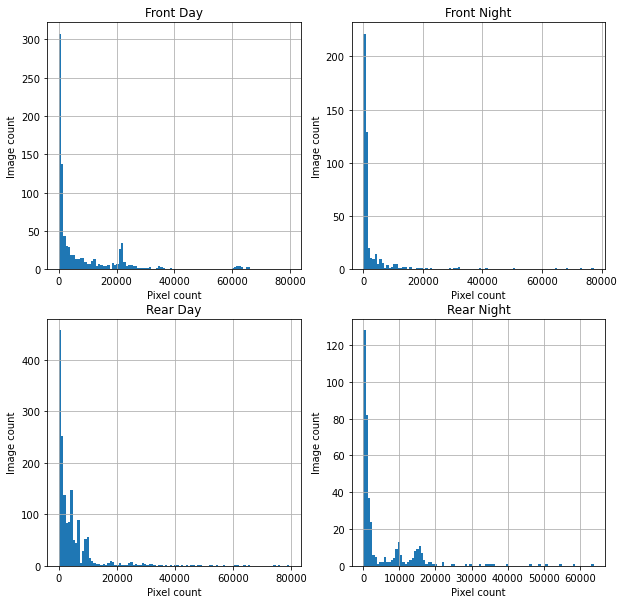

In [32]:
# plot human and vehicle distribution per pod and time
def count_by_pod_time(df, total, print_count=True):
    front_mask = df.camera_location.str.startswith("front")
    day_mask = df.operation_time != "nightime"
    front_day_df = df[front_mask & day_mask]
    front_night_df = df[front_mask & ~day_mask]
    rear_day_df = df[~front_mask & day_mask]
    rear_night_df = df[~front_mask & ~day_mask]
    # print count and ratio
    if print_count:
        print(f'front day {len(front_day_df)} ratio {len(front_day_df)/total:.3f}, night {len(front_night_df)} ratio {len(front_night_df)/total:.3f}, sum {len(front_day_df) + len(front_night_df)} ratio {(len(front_day_df) + len(front_night_df))/total:.3f}')
        print(f'rear day {len(rear_day_df)} ratio {len(rear_day_df)/total:.3f}, night {len(rear_night_df)} ratio {len(rear_night_df)/total:.3f}, sum {len(rear_day_df) + len(rear_night_df)} ratio {(len(rear_day_df) + len(rear_night_df))/total:.3f}')
    return front_day_df, front_night_df, rear_day_df, rear_night_df

def plot_by_pod_time(df, total, cutoff={'Humans': 50000}):
    # cut df to have better plots
    assert len(cutoff) == 1
    key = list(cutoff.keys())[0]
    df = df[df[key] <= cutoff[key]]
    print(f'cut df to {len(df)} by {cutoff}')
    sub_dfs = count_by_pod_time(df, total, print_count=False)
    # plot distribution
    titles = ['Front Day', 'Front Night', 'Rear Day', 'Rear Night']
    plt.figure(1, figsize=(10, 10))
    for i, (sub_df, title) in enumerate(zip(sub_dfs, titles)):
        plt.subplot(2, 2, i+1)
        sub_df[key].hist(bins=100)
        plt.title(title)
        plt.xlabel('Pixel count')
        plt.ylabel('Image count')
    plt.show()

def run(df):
    human_df = df[df.Humans > 0]
    vehicle_df = df[df.Vehicles > 0]
    print('Human stats:')
    print(f'Human images {len(human_df)} out of {len(df)}, ratio {len(human_df) / len(df):.3f}')
    count_by_pod_time(human_df, len(df))
    plot_by_pod_time(human_df, len(df), {'Humans': 50000})

    print('Vehicle stats:')
    print(f'Vehicle images {len(vehicle_df)} out of {len(df)}, ratio {len(vehicle_df) / len(df):.3f}')
    count_by_pod_time(vehicle_df, len(df))
    plot_by_pod_time(vehicle_df, len(df), {'Vehicles': 80000})

run(val_df)

5f9080f28b308cd9a0cd3da3 daytime 2020-10-07T14:51:40.489000


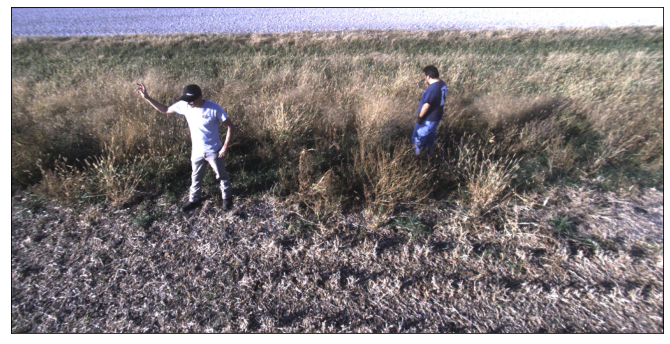

5f9080f28b308cd9a0cd3da3 {'Untilled field': 217964, 'Road': 43216, 'Roadside Buffer': 84296, 'Humans': 15587, 'Tall Weeds': 163225} ['Untilled field', 'Road', 'Roadside Buffer', 'Humans', 'Tall Weeds'] [ 2  3  4 11 24] [217964  43216  84296  15587 163225]


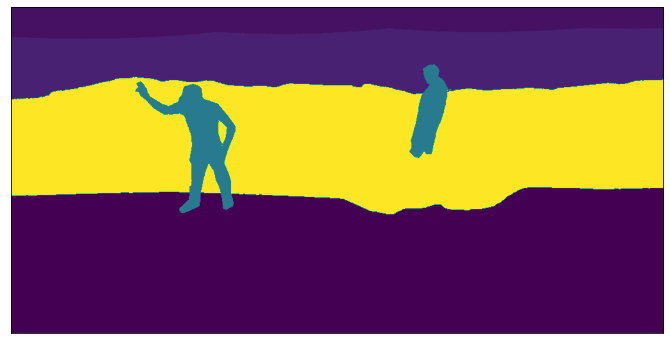

61324e56d7249230ca51abff dawn_dusk 2021-08-28T00:57:25.435000


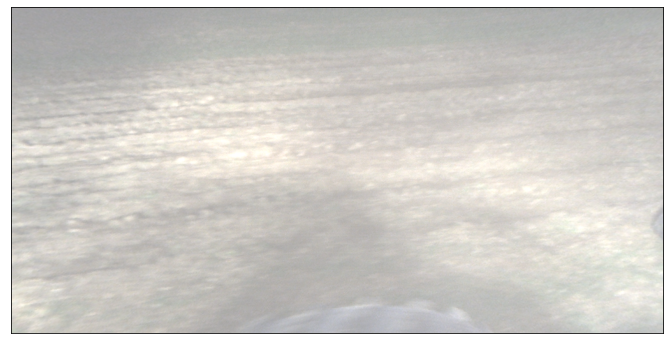

61324e56d7249230ca51abff {'Tilled field': 310684, 'Untilled field': 197685, 'implement': 579, 'Ego Tractor': 15340} ['Tilled field', 'Untilled field', 'implement', 'Ego Tractor'] [ 1  2 14 19] [310684 197685    579  15340]


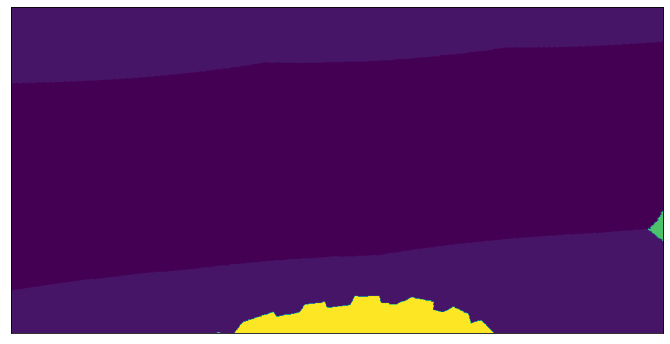

In [4]:
# check if vehicle and object lights overlap
# sub_df = df[(df.operation_time == 'daytime') & (df.state_y == 'true_positive')].sample(2)
sub_df = df.sample(2)
# image_ids = ['61c4303eec85fdd36b96116c', '61e27143c8f15657a286379e']
# sub_df = df[df.image_id.isin(image_ids)]
show_image, show_label, show_depth = True, True, False

for i, row in sub_df.iterrows():
    if show_image:
        data_path = os.path.join(root_dir, row.stereo_pipeline_npz_save_path)
        stereo_data = np.load(data_path)
        img = stereo_data['left']
        img_norm = normalize_image(img, row.hdr_mode)
        print(row.image_id, row.operation_time, row.collected_on)
        plot_image(img_norm)

    if show_label and 'rectified_label_save_path' in row and isinstance(row.rectified_label_save_path, str):
        label_path = os.path.join(root_dir, row.rectified_label_save_path)
        lbl = np.load(label_path)['left']
        labels, counts = np.unique(lbl, return_counts=True)
        label_map = row.label_map
        label_strs = [label_map[str(i)] for i in labels if i != 0]
        print(row.unique_id, row.label_counts, label_strs, labels, counts)
        plot_image(lbl)

### Save sample images

In [3]:
cls4_pred_root = '/data/jupiter/li.yu/exps/driveable_terrain_model/'
train_id = 'v206_510r_rak_local_strong_alb_fine_8cls_tversky11_prod_w002p001d035_r3a8_s30'
dataset = 'Jupiter_2023_03_29_10pm_30_3pm_Loamy_812_stops_stereo_2'
cls4_pred = os.path.join(cls4_pred_root, train_id)
cls4_df = pd.read_csv(os.path.join(cls4_pred, dataset, 'output.csv'))
print(cls4_df.shape)

# dust detection
cls4_dust_df = pd.read_csv(os.path.join(cls4_pred, dataset, 'dust_ratio.csv'))
# merge seg df and dust df
cls4_df = cls4_df.merge(cls4_dust_df, on='id')
print(cls4_df.shape)

# merge with master df to get collected_on
mdf = pd.read_csv(f'/data/jupiter/li.yu/data/{dataset}/master_annotations.csv')
mdf = mdf[['id', 'collected_on', 'hdr_mode', 'stereo_pipeline_npz_save_path']].drop_duplicates(subset=['id'])
print('total master df', mdf.shape)
cls4_df = cls4_df.merge(mdf, on='id').drop_duplicates(subset=['id'])
print('merge master df', cls4_df.shape)

ldf = pd.read_csv(os.path.join(cls4_pred, dataset, 'output.csv'))
ldf = ldf[['id', 'state']]
cls4_df = cls4_df.drop('state', axis=1)
cls4_df = cls4_df.merge(ldf, on='id', how='left').drop_duplicates(subset=['id'])
cls4_df = cls4_df.fillna('true_negative')
cls4_df = cls4_df.replace('large_object_true_positive', 'true_positive')
cls4_df = cls4_df.replace('large_object_false_negative', 'false_negative')
# cls4_df = cls4_df.sort_values('collected_on')
print('merge labeled states', cls4_df.shape)
cls4_df.shape


(36206, 7)
(36206, 15)


/home/li.yu/anaconda3/envs/shank/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3134: DtypeWarning: Columns (37) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


total master df (36206, 4)
merge master df (36206, 18)
merge labeled states (36206, 18)


(36206, 18)

In [4]:
cls4_df.head()

,id,camera_location,operation_time,human_state,vehicle_state,min_pixels_threshold,gt_dust_ratio,pred_dust_ratio,total_averaged_dust_ratio,total_thresholded_dust_ratio,triangle_averaged_dust_ratio,triangle_thresholded_dust_ratio,human_in_triangles_pixels,human_aspect_ratio,collected_on,hdr_mode,stereo_pipeline_npz_save_path,state
0,642709f11620247e22867865,front-left-left,daytime,true_negative,true_negative,400,0.0,0.0,0.001232,0.0,0.001399,0.0,0,true_negative,2023-03-30T14:50:00.057000,True,processed/images/642709f11620247e22867865/ster...,true_negative
1,642709efd7aeccaff79f762e,front-right-left,daytime,true_negative,true_negative,400,0.0,0.0,0.000084,0.0,0.000011,0.0,0,true_negative,2023-03-30T14:50:00.040000,True,processed/images/642709efd7aeccaff79f762e/ster...,true_negative
2,642709f061245ce0ea86f9a7,front-center-left,daytime,true_negative,true_negative,400,0.0,0.0,0.000104,0.0,0.000078,0.0,0,true_negative,2023-03-30T14:50:00.059000,True,processed/images/642709f061245ce0ea86f9a7/ster...,true_negative
3,6425bf80fb0cfb5575aa0e2e,front-left-left,daytime,true_negative,true_negative,400,0.0,0.0,0.001516,0.0,0.000070,0.0,0,true_negative,2023-03-29T23:45:43.216000,True,processed/images/6425bf80fb0cfb5575aa0e2e/ster...,true_negative
4,6425bf81afb870a21b5257ec,front-center-left,daytime,true_negative,true_negative,400,0.0,0.0,0.000038,0.0,0.000010,0.0,0,true_negative,2023-03-29T23:45:43.215000,True,processed/images/6425bf81afb870a21b5257ec/ster...,true_negative


In [5]:
save_dir = f'/data/jupiter/li.yu/data/{dataset}/sample_images'
os.makedirs(save_dir, exist_ok=True)
sub_df = cls4_df[cls4_df.pred_dust_ratio > 0.2]
print(sub_df.shape)
for i,row in sub_df.sample(5).iterrows():
    data_path = os.path.join(f'/data/jupiter/li.yu/data/{dataset}', row.stereo_pipeline_npz_save_path)
    img = np.load(data_path)['left']
    img = normalize_image(img, row.hdr_mode)
    # plot_image(img)
    cv2.imwrite(os.path.join(save_dir, row.id+'.png'), (img*255).astype(np.uint8))

(6981, 18)
